In [1]:
import numpy as np

import ot 
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from scipy.stats import ks_2samp
from sklearn.model_selection import train_test_split
from OTUnawareFairRegressor import OTUnawareFairRegressor 
from data_extraction_script import read_adult_dataset
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
from sklearn.metrics import mean_squared_error

import os
import sys
current_dir = os.getcwd()
folder_path = os.path.abspath(os.path.join(current_dir, 'unaware-fair-reg-3rd-method'))
if folder_path not in sys.path:
    sys.path.insert(0, folder_path)
from FairReg import FairReg
#from evaluation import get_stats, get_risk_unf_wrt_eps
from evaluation_measures import DP_unfairness, prob_unfairness, prob_unfairness_summary, DP_unfairness_summary
#from plots import plot_distributions_compare, plot_predictions_compare, plot_distributions, plot_predictions, plot_risk_history,plot_unfairness_history,plot_unfairness_vs_risk, plot_risk_unf_compare
from data_prep import get_communities_data, get_adult_data, get_frequencies

## Adult Data

In [2]:
"""from ucimlrepo import fetch_ucirepo 

def read_adult_dataset():
    # fetch dataset 
    adult = fetch_ucirepo(id=2) 
    
    # data (as pandas dataframes) 
    X = adult.data.features
    S = X['sex'] #sensitive attribute
    X = X.drop(columns=['sex'])
    y = adult.data.targets 
    
    #metadata 
    #print(adult.metadata) 
    
    # variable information 
    #print(adult.variables) 

    return X,S,y

read_adult_dataset()"""

X, S, y = get_adult_data()

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd

scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))
y = pd.Series(y_scaled.flatten(), index=y.index)

sample_size = 2000 
test_ratio = 1 - (sample_size / len(X))

X, _, S, _, y, _ = train_test_split(
    X, S, y, 
    test_size=test_ratio, 
    random_state=0,
    stratify=S
)

p = get_frequencies(S)

In [5]:
TRAIN_SIZE, UNLAB_SIZE, TEST_SIZE = 0.4, 0.4, 0.2

X_train, X_, S_train, S_, y_train, y_ = train_test_split(X, S, y, train_size = TRAIN_SIZE, stratify = S)
X_unlab, X_test, S_unlab, S_test, y_unlab, y_test = train_test_split(X_, S_, y_, test_size = TEST_SIZE/(1-TRAIN_SIZE), stratify = S_)

In [ ]:
#linear "bayesian" unfair regressor, "eta"
reg = LinearRegression(fit_intercept=True)
reg.fit(X_train,y_train)

LinearRegression()

In [8]:
#logistic classifier for estimating S value from X, "delta" 
clf = LogisticRegression()
clf.fit(X_train,S_train)

LogisticRegression()

In [12]:
T = 100000

fair_reg = FairReg(reg, clf, B=1, K=2,  p=p, eps=[0.00001, 0.00001], T=T, keep_history = False)
fair_reg.fit(X_unlab)

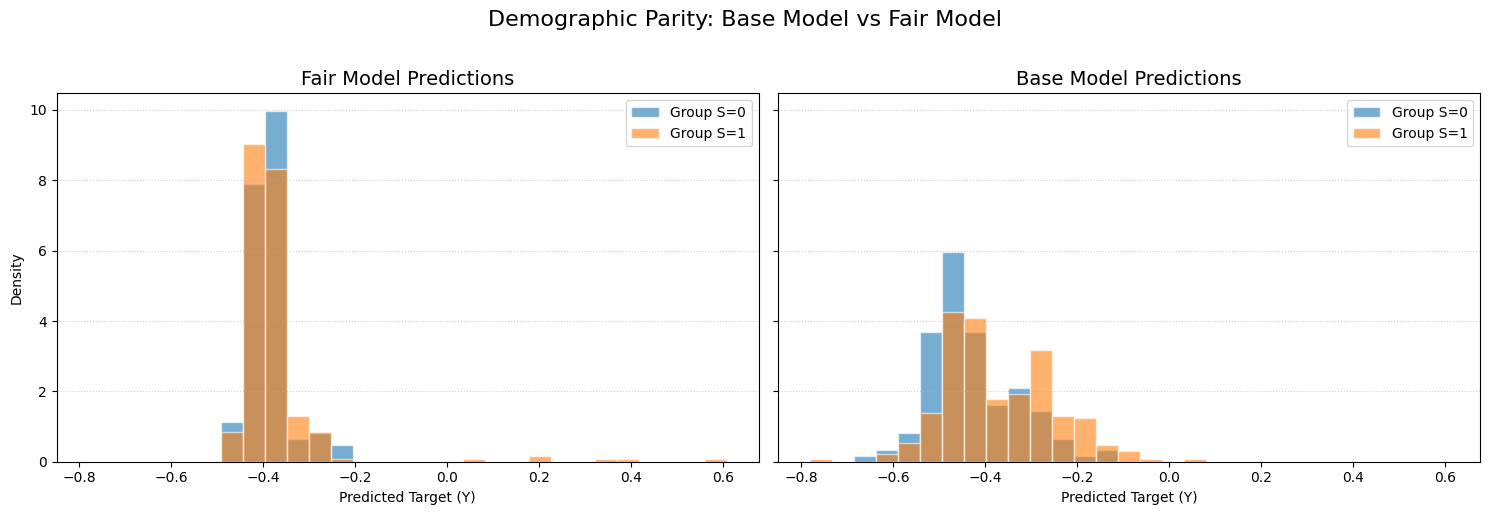

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def plot_distributions_compare(fair_model, base_model, X, S):
    """
    Plots the prediction distributions of a fair model vs a base model, 
    split by sensitive attribute S.
    """
    S_array = np.array(S).flatten()
    S_val = np.sort(np.unique(S_array))
    
    y_pred_fair = fair_model.predict(X)
    y_pred_base = base_model.predict(X)
    

    min_val = min(y_pred_fair.min(), y_pred_base.min())
    max_val = max(y_pred_fair.max(), y_pred_base.max())
    shared_bins = np.linspace(min_val, max_val, 30)
    

    cmap = plt.get_cmap('tab10')
    colors = {S_val[0]: cmap(0), S_val[1]: cmap(1)}
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)


    ax1.set_title("Fair Model Predictions", fontsize=14)
    for s in S_val:
        ax1.hist(y_pred_fair[S_array == s], bins=shared_bins, density=True, 
                 alpha=0.6, color=colors[s], label=f'Group S={s}', edgecolor='white')
    ax1.set_xlabel("Predicted Target (Y)")
    ax1.set_ylabel("Density")
    ax1.legend()
    ax1.grid(axis='y', linestyle=':', alpha=0.6)
        

    ax2.set_title("Base Model Predictions", fontsize=14)
    for s in S_val:
        ax2.hist(y_pred_base[S_array == s], bins=shared_bins, density=True, 
                 alpha=0.6, color=colors[s], label=f'Group S={s}', edgecolor='white')
    ax2.set_xlabel("Predicted Target (Y)")
    ax2.legend()
    ax2.grid(axis='y', linestyle=':', alpha=0.6)
    
    plt.suptitle("Demographic Parity: Base Model vs Fair Model", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

plot_distributions_compare(fair_reg, reg, X_test, S_test)